## Description
In this notebook, I analyze in detail examples of overlapping isotopic envelopes in the mouse bladder and cerebellum images.  
I prepare main figures for the Analytical Chemistry paper, detailing the differences in quantification methods and segmentation algorithms.   

## Data & modules

In [25]:
%matplotlib notebook

In [26]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
import numpy.random as rd
from pyimzml.ImzMLParser import ImzMLParser
from time import time
import pandas as pd
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra

In [27]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_names = ['cerebellum', 'bladder']

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [28]:
profile_average_spectra = {}
for i, n in enumerate(image_names):
    sp = open(n + '_profile_summary_spectrum.tsv')
    next(sp) # skipping the header
    sp = [l.strip().split('\t') for l in sp]
    sp = [(float(l[0]), float(l[1])) for l in sp]
    sp = Spectrum(confs=sp)
    sp.normalize()
    profile_average_spectra[n] = sp

In [29]:
masserstein_estimation = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
single_peak_intensities = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}

In [30]:
masserstein_estimation['cerebellum'].shape

(21, 81, 209)

In [31]:
masserstein_kmeans_segmentation = {n : np.load(n+'_masserstein_kmeans_segmentation.dmp', allow_pickle=True) for n in image_names}
masserstein_sdgmm_segmentation = {n : np.load(n+'_masserstein_sdgmm_segmentation.dmp', allow_pickle=True) for n in image_names}
single_peak_kmeans_segmentation = {n : np.load(n+'_peak_kmeans_segmentation.dmp', allow_pickle=True) for n in image_names}

In [32]:
masserstein_kmeans_segmentation['cerebellum'].shape

(21, 81, 77)

In [33]:
lipid_formulas = {n : [] for n in image_names}
detection_vector = {n: [] for n in image_names}  # used to select lipids in the ion images
for i, n in enumerate(image_names):
    with open(n + '_refined_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            if l[-1] == 'True':  # if the lipid is detected in the image
                lipid_formulas[n].append(l[0])
            detection_vector[n].append(l[-1]=='True')
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 77 formulas for cerebellum
Loaded 44 formulas for bladder


In [34]:
masserstein_estimation = {n: masserstein_estimation[n][..., detection_vector[n]] for n in image_names}
[masserstein_estimation[n].shape for n in image_names]
single_peak_intensities = {n: single_peak_intensities[n][..., detection_vector[n]] for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [35]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()

## Cerebellum case study - peak 783.57 Da, lipids PA(O-40:1) and SM(37:1)

In [39]:
case_name = 'cerebellum_PA_SM'
img = 'cerebellum'
target_mz = 783.57
sp = [[i, s] for i, s in enumerate(lipid_spectra[img]) if abs(s.confs[0][0] - target_mz) < 0.1]
sp_ids = [x[0] for x in sp]
sp = [x[1] for x in sp]
for s in sp:
    s.normalize()
orig_sp_ids = [i for s in sp for i,f in enumerate(orig_lipid_formulas[img]) if f == s.formula]
print('Selected %i spectra, IDs' % len(sp), sp_ids)
print('Original IDs (before removing trace lipids):', orig_sp_ids)

local_mass_range = (782.2, 787)
local_avs = profile_average_spectra[img]
local_avs.confs = [c for c in local_avs.confs if local_mass_range[0] <= c[0] <= local_mass_range[1]]
local_avs.normalize()
local_mz, local_intsy = zip(*local_avs.confs)


Selected 2 spectra, IDs [4, 63]
Original IDs (before removing trace lipids): [4, 63]


In [40]:
formula_to_name = {
    'C43H85O7P': 'PA(O-40:1)', 
    'C42H85N2O6P': 'SM(d18:1/19:0)'
                  }

In [41]:
sp[1].confs

[(783.5782319641501, 0.6125160412030682),
 (784.58158679935, 0.28055672641971885),
 (785.57635073415, 0.04420399371459399),
 (785.58494163455, 0.062723238662619)]

### Test of estimation of kappa

Get the proportions of the theoretical spectra in the target spectrum for visualization.  
To do this, we will fit the theoretical spectra.  
First, detect the stability basin for the kappa parameters.

In [42]:
# kappa_values = np.linspace(0.3, 0, num=51, endpoint=False) 
# props = np.zeros((len(kappa_values), len(kappa_values), 2))
# for ki, k in enumerate(kappa_values):
#     for kthi, kth in enumerate(kappa_values):
#         reg = estimate_proportions(local_avs, sp, MTD=k, MTD_th=kth, progress=False)
#         props[ki, kthi, ...] = reg['proportions']

In [ ]:
# plt.figure()
# plt.plot(kappa_values, props[:,0,0])
# plt.plot(kappa_values, props[:,0,1])

In [ ]:
# plt.figure()
# plt.imshow(np.array([[1,2,3],[4,5,6]]))

<IPython.core.display.Javascript object>


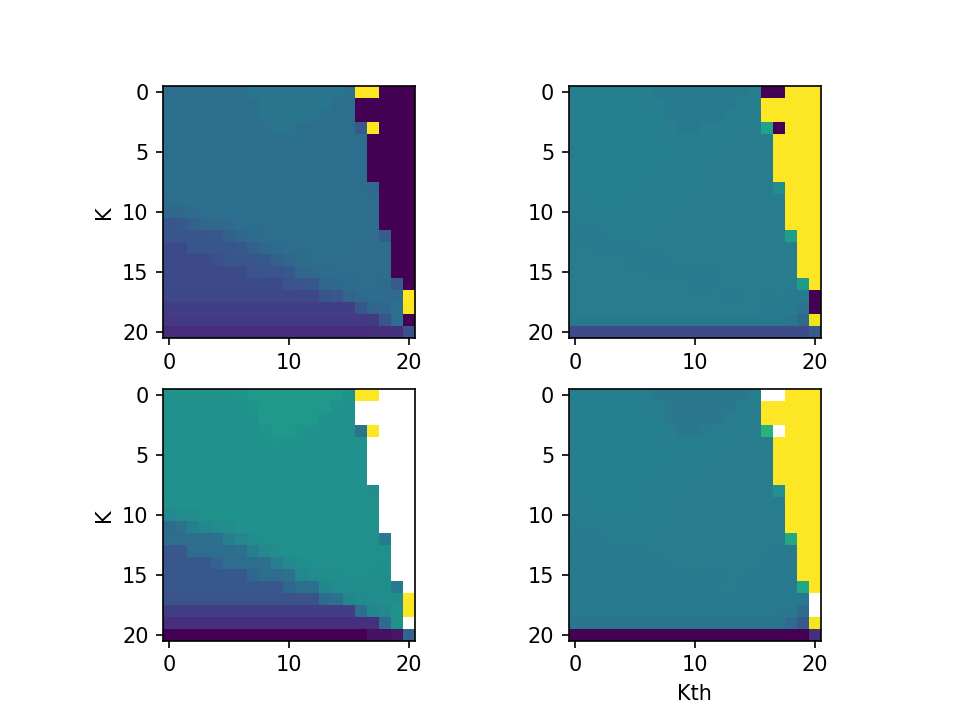

/tmp/ipykernel_6698/3558657894.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(props[...,0]))
/tmp/ipykernel_6698/3558657894.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(props[...,1]))


Text(0.5, 0, 'Kth')

In [33]:
# plt.figure()
# plt.subplot(221)
# plt.imshow(props[...,0])
# plt.ylabel('K')
# plt.subplot(222)
# plt.imshow(props[...,1])
# plt.subplot(223)
# plt.imshow(np.log10(props[...,0]))
# plt.ylabel('K')
# plt.subplot(224)
# plt.imshow(np.log10(props[...,1]))
# plt.xlabel('Kth')

These values give stable results:

In [57]:
# kappa_values[[17, 3]]

array([0.01904762, 0.08571429])

In [42]:
# kappa_values[[19, 18]]

array([0.00952381, 0.01428571])

In [47]:
# print(props[8, 10], props[8, 10,1]/props[8, 10,0])

[0.15792965 0.18573145] 1.1760391532411214


In [46]:
# print(props[19, 18], props[19,18,1]/props[19,18,0])

[0.11573227 0.16794781] 1.4511753038237365


### Fitting the lipids locally for visualization

In [43]:
reg = estimate_proportions(local_avs, sp, MTD=0.019, MTD_th=0.0857, progress=False)
reg['proportions']

[0.09450133078322091, 0.18459509977288008]

In [44]:
# target_heights = [0.00244, 0.00653]
target_heights = np.array([0.09450133078322091, 0.18459509977288008])
target_heights *= (0.00659+0.00256)/np.sum(target_heights)
#target_heights = np.array(reg['proportions'])*(0.00659+0.00256)/np.sum(reg['proportions'])
for i in range(len(sp)):
    ref_conf = sp[i].confs[1]
    # sp[i] = sp[i] * (np.interp(ref_conf[0], local_mz, local_intsy) / ref_conf[1])
    sp[i] = sp[i] * (target_heights[i]/ ref_conf[1])

In [45]:
# sum(y for x,y in sp[1].confs)/ (sum(y for x,y in sp[0].confs) + sum(y for x,y in sp[1].confs))

### Visualization of the lipids spectra on the average spectrum:

Visualize the overlapping lipids on the average profile spectrum:

<IPython.core.display.Javascript object>


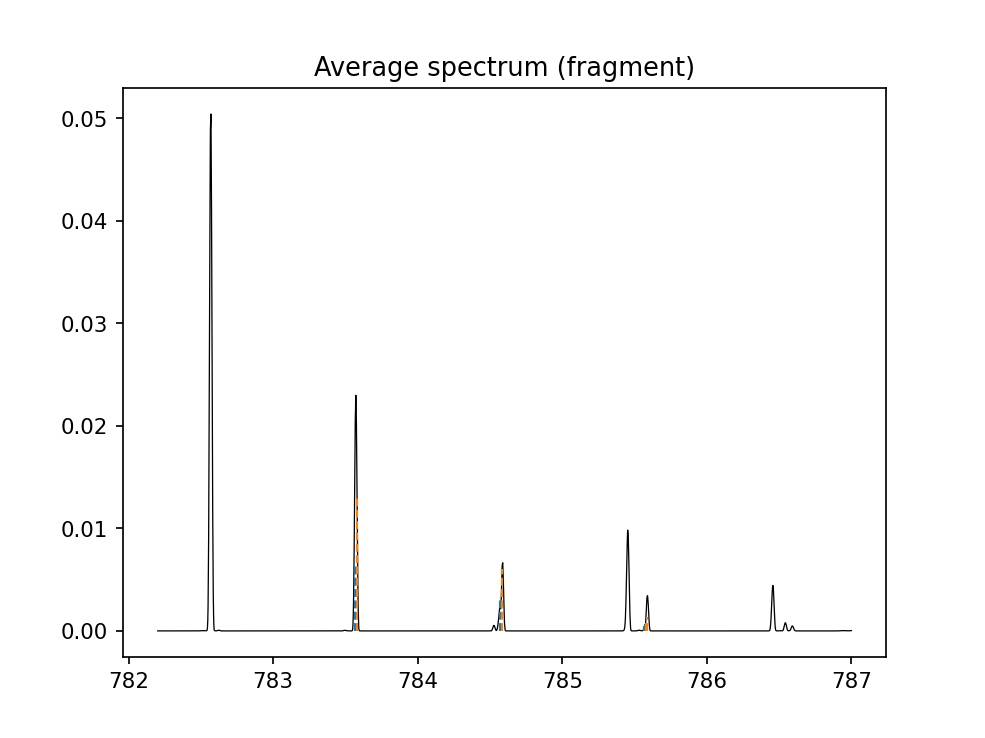

In [46]:
plt.figure()
local_avs.plot(profile=True, color='k', linewidth=0.6)
sp[0].plot(color=cm.tab10(0), ls='--', lw=1)
sp[1].plot(color=cm.tab10(1), ls='--', lw=1)
plt.title('Average spectrum (fragment)')
plt.savefig('Figs/Example deconvolutions/%s_average.png' % case_name, dpi=600)

<IPython.core.display.Javascript object>


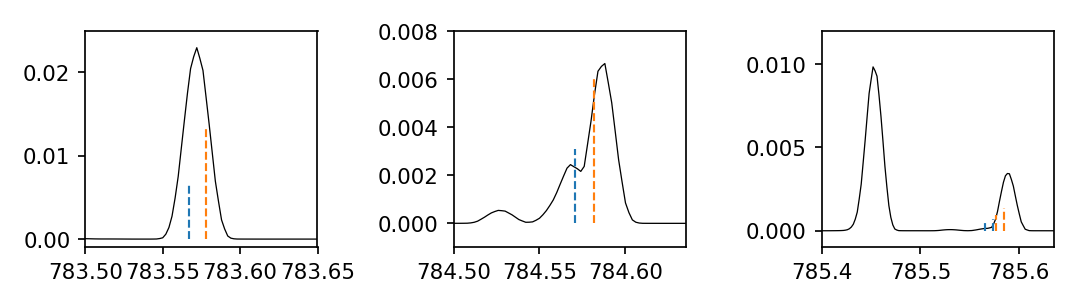

In [47]:
plt.figure(figsize=(7,2))
plt.subplot(131)
local_avs.plot(profile=True, color='k', linewidth=0.6)
sp[0].plot(color=cm.tab10(0), ls='--', lw=1)
sp[1].plot(color=cm.tab10(1), ls='--', lw=1)
plt.xlim(783.50, 783.65)
plt.ylim(-0.001, 0.025)
plt.subplot(132)
local_avs.plot(profile=True, color='k', linewidth=0.6)
sp[0].plot(color=cm.tab10(0), ls='--', lw=1)
sp[1].plot(color=cm.tab10(1), ls='--', lw=1)
plt.xlim(784.50, 784.635)
plt.ylim(-0.001, 0.008)
plt.subplot(133)
local_avs.plot(profile=True, color='k', linewidth=0.6)
sp[0].plot(color=cm.tab10(0), ls='--', lw=1)
sp[1].plot(color=cm.tab10(1), ls='--', lw=1)
plt.xlim(785.40, 785.635)
plt.ylim(-0.001, 0.012)
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_average_zoom.png' % case_name, dpi=600)

### Isotopic peak images:  

Including interfering peaks, M+1 peaks etc

In [48]:
peaks_to_show = [782.5684, 783.5716, 784.5681, 784.5862, 785.4526, 785.5879]
ion_images = [profile_ion_image(profile_images[img], mz) for mz in peaks_to_show]

<IPython.core.display.Javascript object>


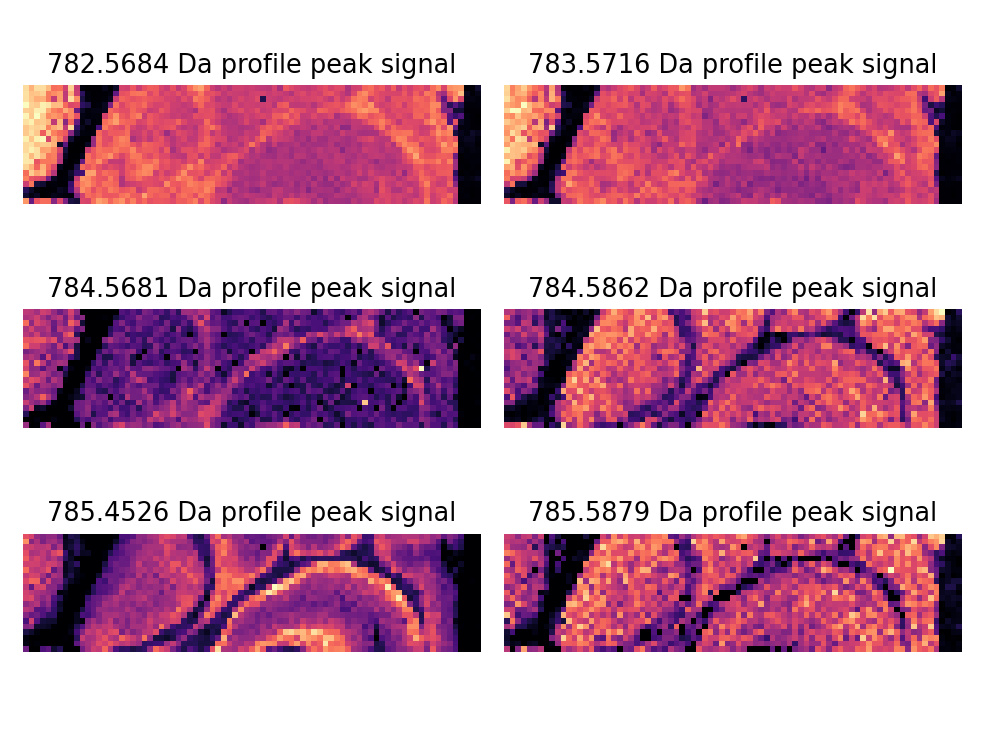

In [49]:
plt.figure()
for i in range(len(ion_images)):
    plt.subplot(len(ion_images)//2, 2, i+1)
    plt.title('%.4f Da profile peak signal' % peaks_to_show[i])
    plt.imshow(ion_images[i], cmap=cm.magma)
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_ion_images.png' % case_name, dpi=400)

### Masserstein images:

In [50]:
sp_ids

[4, 63]

Note, here we use spectrum IDs before removing trace lipids

<IPython.core.display.Javascript object>


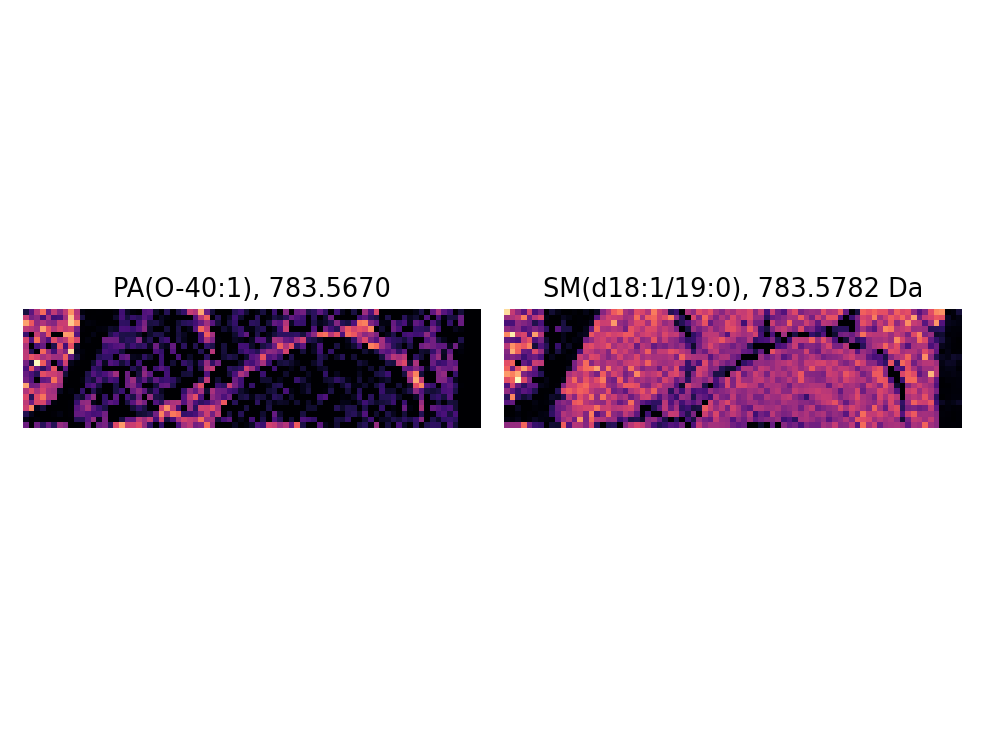

In [51]:
plt.figure()
plt.subplot(121)
plt.imshow(masserstein_estimation[img][...,orig_sp_ids[0]],cmap=cm.magma)
plt.axis('off')
plt.title(formula_to_name[sp[0].label] + ', %.4f' % sp[0].confs[0][0])
plt.subplot(122)
plt.imshow(masserstein_estimation[img][...,orig_sp_ids[1]],cmap=cm.magma)
plt.axis('off')
plt.title(formula_to_name[sp[1].label] + ', %.4f Da' % sp[1].confs[0][0])
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_masserstein_images.png' % case_name, dpi=400)

### Comparing segmentations 

Masserstein + KMeans:

<IPython.core.display.Javascript object>


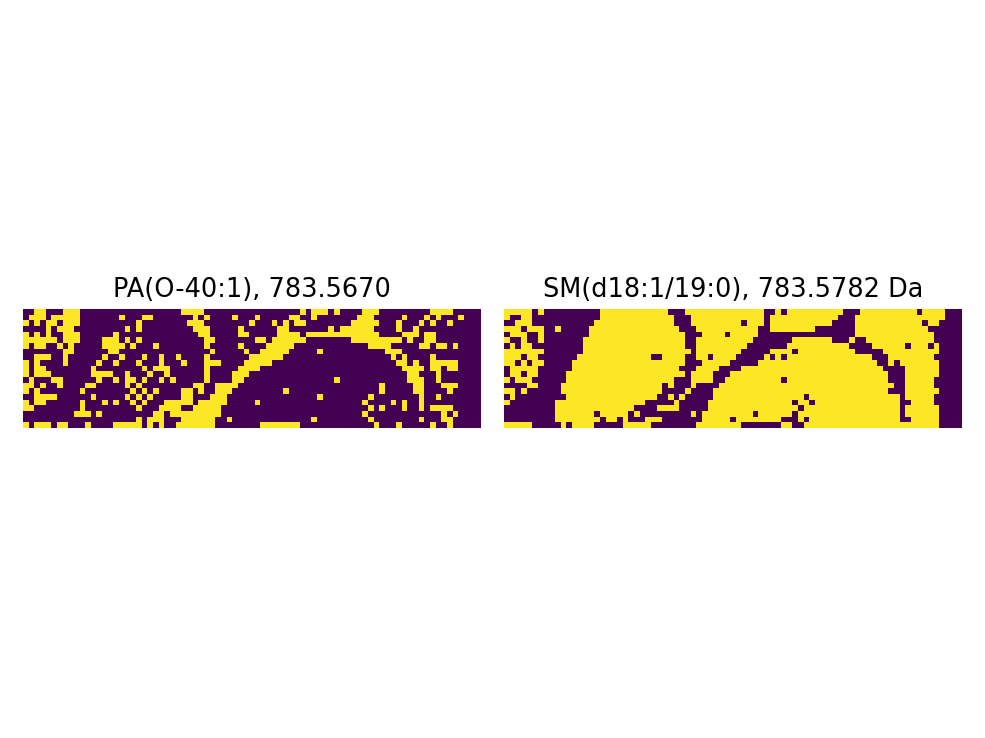

In [38]:
plt.figure()
plt.subplot(121)
plt.imshow(masserstein_kmeans_segmentation[img][...,sp_ids[0]])
plt.axis('off')
plt.title(formula_to_name[sp[0].label] + ', %.4f' % sp[0].confs[0][0])
plt.subplot(122)
plt.imshow(masserstein_kmeans_segmentation[img][...,sp_ids[1]])
plt.axis('off')
plt.title(formula_to_name[sp[1].label] + ', %.4f Da' % sp[1].confs[0][0])
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_mass_kmeans_segm.png' % case_name, dpi=400)

Masserstein + sDGMM:

<IPython.core.display.Javascript object>


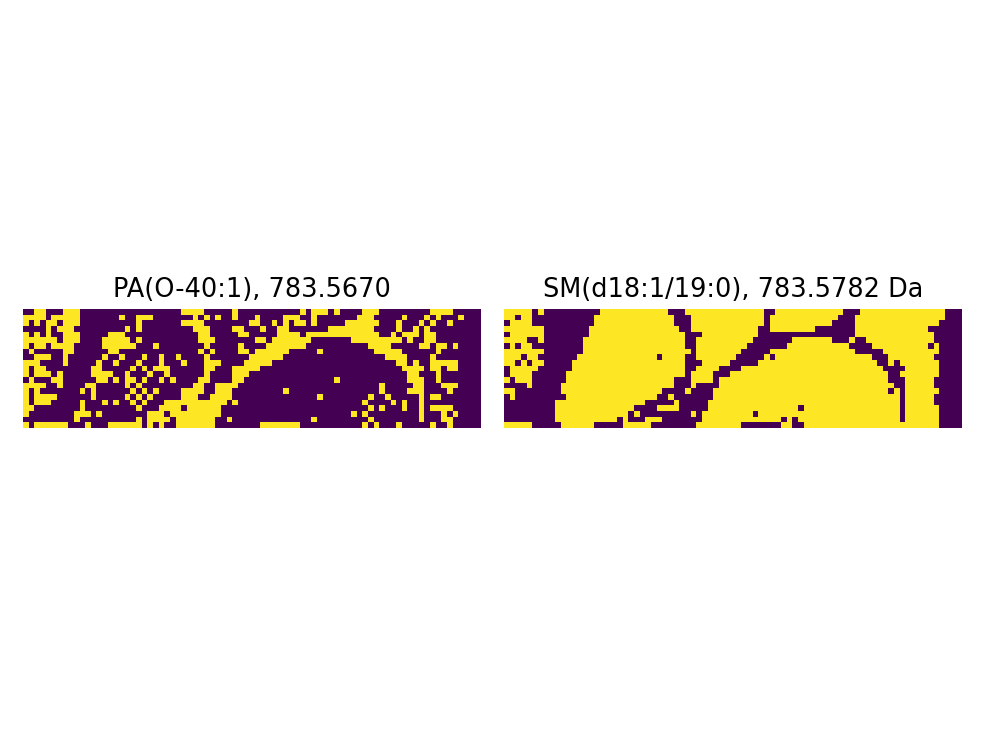

In [39]:
plt.figure()
plt.subplot(121)
plt.imshow(masserstein_sdgmm_segmentation[img][...,sp_ids[0]])
plt.axis('off')
plt.title(formula_to_name[sp[0].label] + ', %.4f' % sp[0].confs[0][0])
plt.subplot(122)
plt.imshow(masserstein_sdgmm_segmentation[img][...,sp_ids[1]])
plt.axis('off')
plt.title(formula_to_name[sp[1].label] + ', %.4f Da' % sp[1].confs[0][0])
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_mass_sdgmm_segm.png' % case_name, dpi=400)

Single peak + Kmeans:

<IPython.core.display.Javascript object>


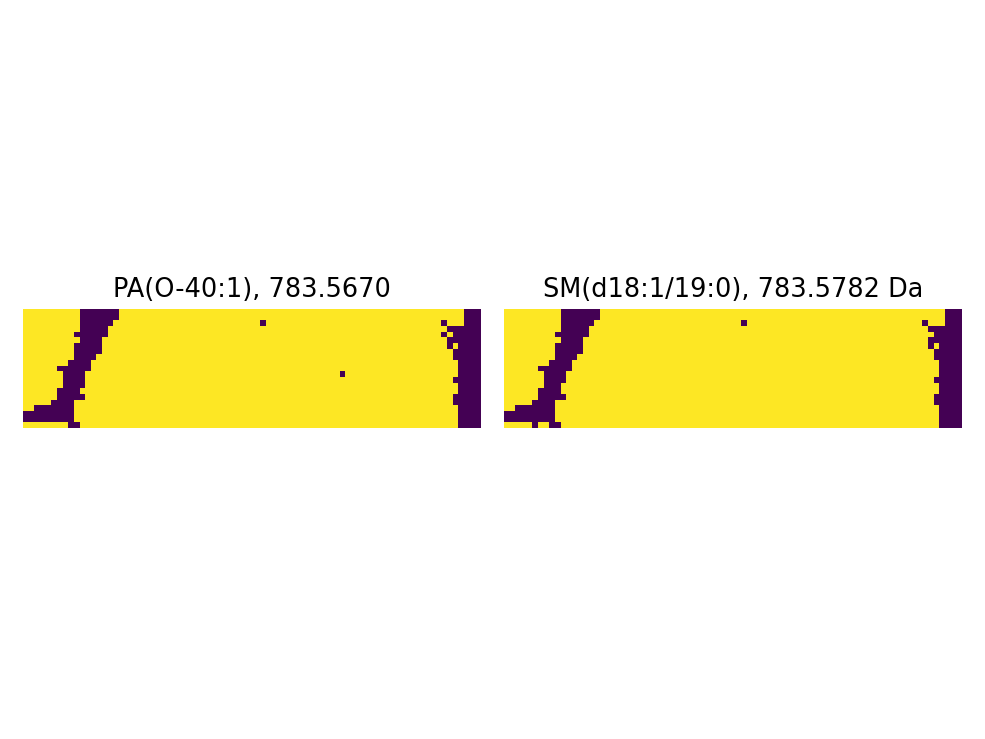

In [40]:
plt.figure()
plt.subplot(121)
plt.imshow(single_peak_kmeans_segmentation[img][...,sp_ids[0]])
plt.axis('off')
plt.title(formula_to_name[sp[0].label] + ', %.4f' % sp[0].confs[0][0])
plt.subplot(122)
plt.imshow(single_peak_kmeans_segmentation[img][...,sp_ids[1]])
plt.axis('off')
plt.title(formula_to_name[sp[1].label] + ', %.4f Da' % sp[1].confs[0][0])
plt.tight_layout()
plt.savefig('Figs/Example deconvolutions/%s_peak_kmeans_segm.png' % case_name, dpi=400)